--- Starting Simulation Phase (Original Agent V1, A->B Task) ---

Generating random graph for Seed 0...
Running Simulation for Seed 0...
 Starting ORIGINAL simulations for Seed 0...
  NOTE: Agent goal: Pathfinding A->B.
  NOTE: Agent using ORIGINAL V1 (Farthest Preferred) strategy.
  NOTE: Selecting start/end nodes OF SAME COLOR.
  NOTE: Computing shortest paths on-the-fly.
  Finished simulations for Seed 0. Completed: 200, Skipped: 0

Generating random graph for Seed 1...
Running Simulation for Seed 1...
 Starting ORIGINAL simulations for Seed 1...
  NOTE: Agent goal: Pathfinding A->B.
  NOTE: Agent using ORIGINAL V1 (Farthest Preferred) strategy.
  NOTE: Selecting start/end nodes OF SAME COLOR.
  NOTE: Computing shortest paths on-the-fly.
  Finished simulations for Seed 1. Completed: 200, Skipped: 0

Generating random graph for Seed 2...
Running Simulation for Seed 2...
 Starting ORIGINAL simulations for Seed 2...
  NOTE: Agent goal: Pathfinding A->B.
  NOTE: Agent using ORIGINAL V1 

ERROR: plot_color_confusion_matrix function not defined.

Pipeline finished.


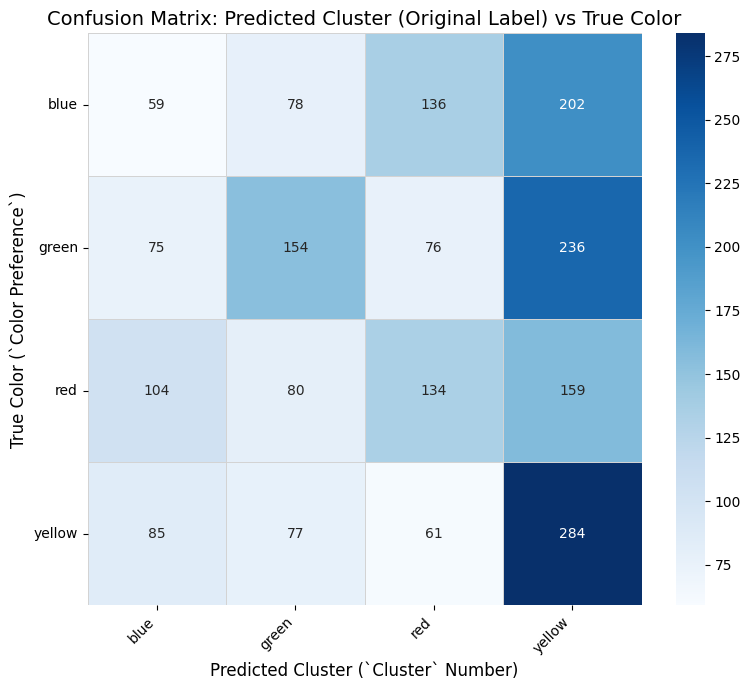

In [2]:
# ==============================================================================
# Imports
# ==============================================================================
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
from typing import List, Dict, Set, Tuple, Any, Optional
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack as sparse_hstack
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment # Although not used in this version's plot
import time
import os
import warnings

# ==============================================================================
# Agent Definition (Original V1 )
# ==============================================================================
class Agent:
    """ Represents the initial agent trying to reach end_node using a
        complex 'farthest preferred neighbor' strategy. """
    def __init__(self, start_node: int, end_node: int, color_preference: str):
        self.start_node: int = start_node
        self.end_node: int = end_node # Target node for pathfinding
        self.color_preference: str = color_preference
        self.current_node: int = start_node
        self.visited_nodes: Set[int] = {start_node} # Avoid cycles
        self.path: List[int] = [start_node]
        self.visited_shapes: List[str] = []
        self.visited_shininess: List[str] = []

    def find_next_node(self, graph: nx.Graph, rng: random.Random) -> Optional[int]:
        """ ORIGINAL V1 STRATEGY:
            Prefers unvisited neighbors matching the agent's color preference.
            Among preferred neighbors, chooses the one FARTHEST from the end_node.
            If no preferred, chooses random unvisited neighbor. """
        neighbors = list(graph.neighbors(self.current_node))
        unvisited_neighbors = [n for n in neighbors if n not in self.visited_nodes]
        if not unvisited_neighbors: return None # Stuck

        preferred_unvisited_neighbors = [
            node for node in unvisited_neighbors
            if graph.nodes.get(node, {}).get('color') == self.color_preference]

        if preferred_unvisited_neighbors:
            try: # Strategy: Choose the preferred neighbor farthest from the end node
                lengths = {}
                for node in preferred_unvisited_neighbors:
                    try: length = nx.shortest_path_length(graph, source=node, target=self.end_node); lengths[node] = length
                    except nx.NetworkXNoPath: lengths[node] = -1 # Treat unreachable as least desirable distance
                if not lengths: return rng.choice(unvisited_neighbors) # Should not happen
                valid_preferred_nodes = {n: l for n, l in lengths.items() if l != -1}
                if valid_preferred_nodes: return max(valid_preferred_nodes, key=valid_preferred_nodes.get)
                else: return rng.choice(preferred_unvisited_neighbors) # All preferred cannot reach end
            except Exception as e: print(f" Warn: Error V1 find_next_node shortest_path: {e}. Fallback."); return rng.choice(preferred_unvisited_neighbors)
        else: # Strategy: If no preferred, choose a random unvisited neighbor
            return rng.choice(unvisited_neighbors)

    def traverse_graph(self, graph: nx.Graph, rng: random.Random) -> Tuple[List[int], int]: # Returns path and pref count
        """ Simulates A->B traversal using the V1 find_next_node strategy. """
        try: start_node_attrs = graph.nodes[self.start_node]; self.visited_shapes.append(start_node_attrs.get('shape', 'unknown')); self.visited_shininess.append(start_node_attrs.get('shiny', 'unknown'))
        except KeyError: self.visited_shapes.append('unknown'); self.visited_shininess.append('unknown')

        while self.current_node != self.end_node:
            next_node = self.find_next_node(graph, rng) # Calls V1 logic
            if next_node is None: break # Stuck
            self.visited_nodes.add(next_node); self.path.append(next_node); self.current_node = next_node;
            try: node_attrs = graph.nodes[next_node]; self.visited_shapes.append(node_attrs.get('shape', 'unknown')); self.visited_shininess.append(node_attrs.get('shiny', 'unknown'))
            except KeyError: self.visited_shapes.append('unknown'); self.visited_shininess.append('unknown')

        preferred_color_path_count = sum(1 for node_id in self.path if graph.nodes.get(node_id, {}).get('color') == self.color_preference)
        # Original return signature is path, pref_count
        return self.path, preferred_color_path_count

# ==============================================================================
# Graph Generation (Random Colors Version)
# ==============================================================================
def generate_colored_graph(num_nodes: int, colors: List[str], edge_probability: float,
                           node_color_seed: int, edge_seed: int) -> nx.Graph: # Original param names
    """ Generates a random graph with random node colors and attributes. """
    G = nx.Graph()
    # Use separate Random instances for reproducibility
    node_rng = random.Random(node_color_seed)
    edge_rng = random.Random(edge_seed)
    shapes = ['circle', 'square', 'triangle']
    shininess_options = ['shiny', 'not_shiny']

    for i in range(1, num_nodes + 1):
        color = node_rng.choice(colors) # Pure random color assignment
        shape = node_rng.choice(shapes)
        shininess = node_rng.choice(shininess_options)
        G.add_node(i, color=color, shape=shape, shiny=shininess)

    for i in range(1, num_nodes + 1):
        for j in range(i + 1, num_nodes + 1):
            if edge_rng.random() < edge_probability:
                G.add_edge(i, j)

    # Check connectivity
    # if num_nodes > 0 and not nx.is_connected(G): warnings.warn(...)

    return G

# ==============================================================================
# Simulation (Original A->B Task with potential same start/end color constraint)
# ==============================================================================
def simulate_agents_original_task(graph: nx.Graph, num_agents: int, num_traversals_per_agent: int,
                                 simulation_seed: int, edge_probability: float,
                                 min_distance: int = 4,
                                 colors_list: List[str] = ['blue', 'green', 'red', 'yellow'],
                                 require_same_color_start_end: bool = True # Flag for constraint
                                 ) -> pd.DataFrame:
    """ Simulates agents performing A->B task using original V1 agent.
        Includes constraint for start/end node colors. """
    agent_data = []; node_id_to_color_name = {node: graph.nodes[node].get('color', 'unknown') for node in graph.nodes()}
    sim_rng = random.Random(simulation_seed); print(f" Starting ORIGINAL simulations for Seed {simulation_seed}...")
    total_simulations = num_agents * num_traversals_per_agent; completed_simulations = 0; skipped_simulations = 0
    print("  NOTE: Agent goal: Pathfinding A->B."); print("  NOTE: Agent using ORIGINAL V1 (Farthest Preferred) strategy.");
    if require_same_color_start_end: print("  NOTE: Selecting start/end nodes OF SAME COLOR.")
    else: print("  NOTE: Selecting random start/end nodes.")
    print("  NOTE: Computing shortest paths on-the-fly.")

    nodes_list = list(graph.nodes())
    if len(nodes_list) < 2: print(" Error: Graph has < 2 nodes."); return pd.DataFrame(agent_data)

    for i in range(total_simulations):
        agent_id = i % num_agents; start_node, end_node = None, None
        attempts = 0; max_attempts = max(500, 20 * graph.number_of_nodes())

        # --- Original Start/End Node Selection Loop ---
        while attempts < max_attempts:
            attempts += 1
            start_node = sim_rng.choice(nodes_list)
            start_color = graph.nodes[start_node]['color']

            if require_same_color_start_end:
                 valid_end_nodes = [n for n in nodes_list if graph.nodes[n]['color'] == start_color and n != start_node]
                 if not valid_end_nodes: continue # Try different start node
                 end_node = sim_rng.choice(valid_end_nodes)
            else: # Select any other node randomly
                 potential_end_nodes = [n for n in nodes_list if n != start_node]
                 if not potential_end_nodes: break # Only one node in graph?
                 end_node = sim_rng.choice(potential_end_nodes)

            # Check distance
            distance = -1
            try: distance = nx.shortest_path_length(graph, source=start_node, target=end_node)
            except nx.NetworkXNoPath: continue # Not connected
            except Exception as e: print(f" Warning: Error finding shortest path ({start_node}-{end_node}): {e}"); start_node, end_node = None, None; continue
            if distance >= min_distance: break # Found valid pair
        # --- End Selection Loop ---

        if start_node is None or end_node is None: skipped_simulations += 1; continue

        color_preference = sim_rng.choice(colors_list)
        agent = Agent(start_node, end_node, color_preference) # Create Agent V1

        try: path, preferred_color_path_count = agent.traverse_graph(graph, sim_rng); # Call V1 traverse_graph
        except Exception as e: print(f" Error during agent traversal call (Start: {start_node}, Pref: {color_preference}): {repr(e)}"); skipped_simulations += 1; continue
        if not path: print(f"  Warning: Traversal returned empty path (Start: {start_node}). Skipping."); skipped_simulations += 1; continue

        mapped_colors = [node_id_to_color_name.get(node, 'unknown') for node in agent.path]; path_len = len(agent.path);
        pref_prop = (preferred_color_path_count / path_len) if path_len > 0 else 0.0
        # Store data, including 'End Node'
        agent_data.append({'Seed': simulation_seed, 'Agent': agent_id, 'Start Node': start_node, 'End Node': end_node, 'Color Preference': color_preference, 'Path Length': path_len, 'Preferred Color Path Count': preferred_color_path_count, 'Preferred_Color_Proportion': pref_prop, 'Path': agent.path, 'Mapped Colors': mapped_colors, 'Visited Shapes': agent.visited_shapes, 'Visited Shininess': agent.visited_shininess, 'Density': edge_probability }); completed_simulations += 1
    print(f"  Finished simulations for Seed {simulation_seed}. Completed: {completed_simulations}, Skipped: {skipped_simulations}")
    return pd.DataFrame(agent_data)

# ==============================================================================
# Clustering Feature Engineering / Distance Calculation
# ==============================================================================
# (Functions jaccard_distance, extract_boc_features, extract_combined_features, calculate_distance_matrix)

def jaccard_distance(set1: Any, set2: Any) -> float:
    try: set1 = set(set1) if isinstance(set1, (list, tuple, np.ndarray)) else set(set1) if set1 is not None else set(); set2 = set(set2) if isinstance(set2, (list, tuple, np.ndarray)) else set(set2) if set2 is not None else set()
    except TypeError: return 1.0
    intersection = len(set1.intersection(set2)); union = len(set1.union(set2));
    if union == 0: return 0.0
    return 1.0 - intersection / union

def extract_boc_features(group: pd.DataFrame) -> Optional[Any]:
     if 'Mapped Colors' not in group.columns: print("Error:'Mapped Colors'"); return None
     group['Mapped Colors'] = group['Mapped Colors'].apply(lambda x: x if isinstance(x, list) else []) # Ensure list
     corpus = group['Mapped Colors'].apply(lambda colors: ' '.join(map(str, colors)))
     try: vectorizer = CountVectorizer(); X = vectorizer.fit_transform(corpus); print(f"  BoC Features extracted with shape: {X.shape}"); return X
     except Exception as e: print(f"  Error extracting BoC features: {e}"); return None

def extract_combined_features(group: pd.DataFrame) -> Optional[Any]:
    print("  Extracting Combined Features (BoC + Numerical)..."); boc_features = extract_boc_features(group);
    if boc_features is None: return None
    num_cols = ['Path Length', 'Preferred_Color_Proportion'] 
    if not all(col in group.columns for col in num_cols): print(f"Error: Missing {num_cols}"); return None
    try: numerical_features = group[num_cols].values.astype(float)
    except Exception as e: print(f"Error accessing numerical features: {e}"); return None
    try: scaler = StandardScaler(); scaled_numerical = scaler.fit_transform(numerical_features)
    except Exception as e: print(f"Error scaling numerical features: {e}"); return None
    try: combined_features = sparse_hstack((boc_features.tocsr(), scaled_numerical), format='csr'); print(f"  Combined Features shape: {combined_features.shape}"); return combined_features
    except Exception as e: print(f"Error combining features: {e}"); return None

def calculate_distance_matrix(group: pd.DataFrame, method: str = 'jaccard', **kwargs) -> Tuple[Optional[np.ndarray], Optional[Any], bool, str]:
    num_samples = len(group); metric_used = method; distance_matrix = None; feature_matrix = None; is_valid = False
    if method == 'jaccard':
        metric_used = 'jaccard';
        if 'Path' not in group.columns: print("Error:'Path'"); return None, None, False, metric_used
        group['Path_Set'] = group['Path'].apply(lambda x: set(x) if isinstance(x, (list, tuple)) else set())
        distance_matrix_calc = np.zeros((num_samples, num_samples)); path_sets = group['Path_Set'].tolist()
        for i in range(num_samples):
            for j in range(i + 1, num_samples):
                try: dist = jaccard_distance(path_sets[i], path_sets[j]);
                except Exception as e: print(f"Error Jaccard({i},{j}): {e}"); return None, None, False, metric_used
                if not np.isfinite(dist): raise ValueError(f"Invalid Jaccard dist: {dist}")
                distance_matrix_calc[i, j] = dist; distance_matrix_calc[j, i] = dist
        distance_matrix = distance_matrix_calc; is_valid = True
    elif method == 'boc':
        metric_used = kwargs.get('metric', 'cosine'); feature_matrix = extract_boc_features(group)
        if feature_matrix is not None:
            try: condensed_distances = pdist(feature_matrix.toarray(), metric=metric_used); distance_matrix = squareform(condensed_distances); print(f"  BoC Features + '{metric_used}' distance matrix calculated."); is_valid = True
            except Exception as e: print(f"Warn: Could not create distance matrix from BoC: {e}"); is_valid = True
        else: return None, None, False, 'boc'
    elif method == 'combined':
         metric_used = kwargs.get('metric', 'euclidean'); feature_matrix = extract_combined_features(group)
         if feature_matrix is not None: is_valid = True; distance_matrix = None; print(f"  Combined features extracted. Assoc metric: '{metric_used}'")
         else: is_valid = False
         return distance_matrix, feature_matrix, is_valid, metric_used
    else: print(f"Error: Unknown method '{method}'."); return None, None, False, 'unknown'
    return distance_matrix, feature_matrix, is_valid, metric_used


# ==============================================================================
# Clustering and Evaluation Function 
# ==============================================================================

def cluster_and_evaluate(df: pd.DataFrame, n_clusters: int = 4, feature_distance_method: str = 'jaccard', cluster_method: str = 'ward', dist_metric_param: str = 'cosine', linkage_method: str = 'ward' ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Adjust required cols check based on simulation output
    required_cols = ['Seed', 'Color Preference', 'Mapped Colors'] 
    if feature_distance_method == 'jaccard': required_cols.append('Path')
    elif feature_distance_method == 'combined': required_cols.extend(['Path Length', 'Preferred Color Path Count', 'Path', 'Mapped Colors'])
    elif feature_distance_method == 'boc': required_cols.extend(['Path', 'Mapped Colors']) # Path needed for helper

    if not all(col in df.columns for col in required_cols): raise ValueError(f"Missing columns for eval: {required_cols}. Available: {df.columns.tolist()}")
    print(f"\n--- Starting Clustering Evaluation ---"); print(f" Feature/Distance Method: {feature_distance_method}"); print(f" Clustering Algorithm: {cluster_method}"); print(f" Target Clusters (k): {n_clusters}")
    results_summary = []; processed_groups = []
    for seed, group in df.groupby('Seed'):
        print(f" Processing Seed {seed}..."); group = group.copy(); num_samples = len(group); group['Cluster'] = -1
        if num_samples < 2: print(f"  Skipping Seed {seed}: Samples < 2."); processed_groups.append(group); continue
        distance_matrix, feature_matrix, is_valid, eval_metric = calculate_distance_matrix(group, method=feature_distance_method, metric=dist_metric_param)
        if not is_valid: processed_groups.append(group); continue
        clusters = None; actual_n_clusters = min(n_clusters, num_samples) if num_samples > 0 else 1;
        if actual_n_clusters < 1: actual_n_clusters = 1
        try: # Clustering Block
            if cluster_method in ['ward', 'complete', 'average', 'single']: # Hierarchical
                 linkage_input_dm = distance_matrix
                 if linkage_input_dm is None:
                      if feature_matrix is not None:
                           print(f"  Calculating '{dist_metric_param}' distance matrix for hierarchical on features...")
                           try: linkage_input_dm = squareform(pdist(feature_matrix.toarray(), metric=dist_metric_param))
                           except Exception as e_pdist: raise ValueError(f"Failed distance calc for hierarchical: {e_pdist}") from e_pdist
                      else: raise ValueError("Neither distance matrix nor features available.")
                 if not isinstance(linkage_input_dm, np.ndarray) or linkage_input_dm.ndim!=2 or linkage_input_dm.shape[0]!=linkage_input_dm.shape[1]: raise ValueError("Invalid DM shape.")
                 if np.isnan(linkage_input_dm).any() or np.isinf(linkage_input_dm).any(): raise ValueError("NaN/Inf in DM.")
                 if not np.allclose(linkage_input_dm, linkage_input_dm.T): warnings.warn(f"DM not symmetric (Seed {seed}).", stacklevel=2); linkage_input_dm = (linkage_input_dm + linkage_input_dm.T) / 2
                 np.fill_diagonal(linkage_input_dm, 0)
                 try: condensed_distance = squareform(linkage_input_dm, checks=True)
                 except ValueError as sq_err: raise ValueError(f"Squareform check failed: {sq_err}") from sq_err
                 if condensed_distance is None or not np.isfinite(condensed_distance).all(): raise ValueError("Invalid condensed distance array.")
                 Z = linkage(condensed_distance, method=cluster_method);
                 if Z is None or not isinstance(Z, np.ndarray): raise TypeError("Linkage failed.")
                 clusters = fcluster(Z, t=actual_n_clusters, criterion='maxclust')
                 if clusters is None or not isinstance(clusters, np.ndarray): raise TypeError("fcluster failed.")
            elif cluster_method in ['kmeans', 'gmm']: # Feature-based
                current_feature_matrix = feature_matrix
                if current_feature_matrix is None:
                     if feature_distance_method == 'boc': _, current_feature_matrix, _, _ = calculate_distance_matrix(group, 'boc', metric=dist_metric_param)
                     elif feature_distance_method == 'combined': _, current_feature_matrix, _, _ = calculate_distance_matrix(group, 'combined', metric=dist_metric_param)
                     if current_feature_matrix is None: raise ValueError(f"Features required for {cluster_method}.")
                if cluster_method == 'kmeans': kmeans = KMeans(n_clusters=actual_n_clusters, random_state=seed, n_init=10, verbose=0); clusters = kmeans.fit_predict(current_feature_matrix); clusters += 1
                elif cluster_method == 'gmm': gmm = GaussianMixture(n_components=actual_n_clusters, random_state=seed, verbose=0, n_init=5); clusters = gmm.fit_predict(current_feature_matrix.toarray()); clusters += 1
            else: raise ValueError(f"Unsupported cluster_method: {cluster_method}")
            group['Cluster'] = clusters; num_unique_clusters_found = len(set(c for c in clusters if c != -1))
        except Exception as e: print(f"  Error during clustering for Seed {seed}: {repr(e)}"); processed_groups.append(group); continue
        # --- Evaluation ---
        silhouette_avg = np.nan; ari_score = np.nan; nmi_score = np.nan
        valid_cluster_mask = group['Cluster'] != -1; clusters_for_eval = group.loc[valid_cluster_mask, 'Cluster']
        num_valid_samples_for_eval = len(clusters_for_eval); num_clusters_for_eval = len(set(clusters_for_eval))
        if num_clusters_for_eval > 1 and num_clusters_for_eval < num_valid_samples_for_eval: # Silhouette Calc
            silhouette_input_data = None; silhouette_metric = 'euclidean' # Default
            can_use_precomputed = (distance_matrix is not None)
            if can_use_precomputed and (feature_distance_method == 'jaccard' or cluster_method in ['ward', 'complete', 'average', 'single']):
                silhouette_metric = 'precomputed'; valid_mask_np = valid_cluster_mask.to_numpy()
                if len(valid_mask_np) == distance_matrix.shape[0]:
                     valid_distance_matrix = distance_matrix[np.ix_(valid_mask_np, valid_mask_np)]
                     if valid_distance_matrix.shape[0] > 1:
                         try: silhouette_avg = silhouette_score(valid_distance_matrix, clusters_for_eval, metric='precomputed')
                         except Exception as e_sil: print(f"   Warning: Silhouette (precomputed) error: {repr(e_sil)}")
                else: print(f"   Warning: Index mismatch Silhouette submatrix (Seed {seed}).")
            elif feature_matrix is not None: # Try features
                current_feature_matrix = feature_matrix
                if current_feature_matrix.shape[0] == num_samples:
                    valid_feature_matrix = current_feature_matrix[valid_cluster_mask]
                    if valid_feature_matrix.shape[0] > 1:
                        try: silhouette_avg = silhouette_score(valid_feature_matrix, clusters_for_eval, metric=eval_metric) # Use metric assoc. with features
                        except Exception as e_sil: print(f"   Warning: Silhouette (feature, metric='{eval_metric}') error: {repr(e_sil)}")
                else: print(f"   Warning: Feature matrix shape mismatch Silhouette (Seed {seed}).")
            if silhouette_avg is np.nan and num_clusters_for_eval > 1:
                 print(f"   Skipping Silhouette: Input data invalid or unavailable (Seed {seed})")
        if num_valid_samples_for_eval > 0: # ARI/NMI Calc
             try: true_labels_for_eval = group.loc[valid_cluster_mask, 'Color Preference']; ari_score = adjusted_rand_score(true_labels_for_eval, clusters_for_eval); nmi_score = normalized_mutual_info_score(true_labels_for_eval, clusters_for_eval)
             except Exception as e_gnd: print(f"   Warning: Could not compute ARI/NMI Seed {seed}: {repr(e_gnd)}")
        formatted_cluster_color_percentages = {}; max_color_separation = np.nan
        try: # Purity Calc
            valid_group_for_purity = group[group['Cluster'] != -1]
            if not valid_group_for_purity.empty:
                if 'Mapped Colors' in valid_group_for_purity.columns:
                    exploded_group = valid_group_for_purity.explode('Mapped Colors').dropna(subset=['Mapped Colors']); exploded_group.rename(columns={'Mapped Colors': 'Flat Colors'}, inplace=True)
                    color_counts = exploded_group.groupby(['Cluster', 'Flat Colors']).size().unstack(fill_value=0)
                    all_possible_colors = sorted(df['Color Preference'].dropna().unique())
                    for color in all_possible_colors:
                        if color not in color_counts.columns: color_counts[color] = 0
                    color_counts = color_counts[all_possible_colors]; cluster_sums = color_counts.sum(axis=1); safe_sums = cluster_sums.replace(0, 1)
                    color_percentages = color_counts.div(safe_sums, axis=0).mul(100); cluster_color_percentages_dict = color_percentages.round(2).apply(lambda r: r.dropna().to_dict(), axis=1).to_dict()
                    formatted_cluster_color_percentages = {int(k): {c: f"{p:.2f}%" for c, p in v.items()} for k, v in cluster_color_percentages_dict.items()}
                    if not color_percentages.empty: max_color_separation = color_percentages.apply(lambda r: r.max() - r.min() if not r.empty else 0.0, axis=1).max()
                    else: max_color_separation = 0.0
                else: print(f"   Warning: 'Mapped Colors' column missing for purity calc (Seed {seed}).")
        except Exception as e: print(f"   Warning: Color percentage error Seed {seed}: {e}")
        results_summary.append({'Seed': seed, 'Algorithm': cluster_method, 'Feature_Metric': f"{feature_distance_method}({eval_metric})", 'Num_Clusters_Target': n_clusters, 'Num_Clusters_Found': num_clusters_for_eval, 'Cluster_Color_Percentage': formatted_cluster_color_percentages, 'Silhouette': silhouette_avg, 'ARI': ari_score, 'NMI': nmi_score, 'Max_Color_Separation': max_color_separation })
        processed_groups.append(group)
    if not processed_groups: warnings.warn("No groups processed."); return pd.DataFrame(results_summary), df.copy()
    df_with_clusters = pd.concat(processed_groups).reset_index(drop=True); results_summary_df = pd.DataFrame(results_summary)
    print("\nClustering and evaluation complete.")
    return results_summary_df, df_with_clusters

# ==============================================================================
# Plotting Functions (Unchanged)
# ==============================================================================
# (plot_colored_graph and plot_color_confusion_matrix definitions identical)
def plot_colored_graph(G: nx.Graph, seed: int, output_dir: str = "plots"):
    if not os.path.exists(output_dir): os.makedirs(output_dir); filepath = os.path.join(output_dir, f"graph_seed_{seed}.png")
    plt.figure(figsize=(12, 10)); pos = nx.spring_layout(G, seed=42); node_colors = [G.nodes[node].get('color', 'gray') for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, alpha=0.9); nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(f"Graph Structure (Seed {seed})", fontsize=16); plt.axis('off'); plt.tight_layout(); plt.savefig(filepath); print(f" Saved graph plot to {filepath}"); plt.close()

def plot_color_confusion_matrix(df: pd.DataFrame, cluster_col: str = 'Cluster', true_color_col: str = 'Color Preference', figsize: Tuple[int, int] = (8, 7), cmap: str = 'Blues', output_dir: str = "plots"):
    # Plots without remapping
    if not os.path.exists(output_dir): os.makedirs(output_dir); plot_filename = f"confusion_matrix_{cluster_col}_vs_{true_color_col}_ORIGINAL_LABELS.png"; filepath = os.path.join(output_dir, plot_filename) # Changed filename
    if cluster_col not in df.columns: raise ValueError(f"Cluster column '{cluster_col}' not found.")
    if true_color_col not in df.columns: raise ValueError(f"True color column '{true_color_col}' not found.")
    df_valid = df[pd.to_numeric(df[cluster_col], errors='coerce').notna()].copy(); df_valid[cluster_col] = df_valid[cluster_col].astype(int); df_valid = df_valid[df_valid[cluster_col] > 0] # Use only valid clusters
    if df_valid.empty: print("Warning: No valid data for confusion matrix."); return
    unique_colors = sorted(df_valid[true_color_col].dropna().unique());
    if not unique_colors: print(f"Error: No valid unique values in '{true_color_col}'."); return
    color_to_int_mapping = {color: i + 1 for i, color in enumerate(unique_colors)}; mapped_color_ints = list(color_to_int_mapping.values()); mapped_color_names = list(color_to_int_mapping.keys())
    print(f"\n--- Confusion Matrix Generation (Original Labels) ---"); print(f" Using Color Mapping for Plot Axes: {color_to_int_mapping}")
    try: y_true = df_valid[true_color_col].map(color_to_int_mapping); y_pred = df_valid[cluster_col] # Use original cluster column
    except Exception as e: print(f" Error preparing y_true/y_pred: {e}"); return
    valid_indices = y_true.notna()
    if not valid_indices.all(): y_true = y_true[valid_indices].astype(int); y_pred = y_pred[valid_indices]
    if len(y_true) == 0: print(" Error: No samples for confusion matrix."); return
    # Ensure labels cover the actual range present in predictions and true mapped labels
    present_pred_labels = sorted(y_pred.unique().astype(int))
    matrix_labels_expected = sorted(list(set(mapped_color_ints) | set(present_pred_labels))) # Union of possible labels
    mapped_label_names_ordered = {v:k for k,v in color_to_int_mapping.items()}
    plot_axis_names = [mapped_label_names_ordered.get(l, f"Cluster {l}") for l in matrix_labels_expected] # Get names for axes

    conf_matrix = confusion_matrix(y_true, y_pred, labels=matrix_labels_expected); conf_matrix_df = pd.DataFrame(conf_matrix, index=plot_axis_names, columns=plot_axis_names) # Use consistent names
    plt.figure(figsize=figsize); sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap=cmap, cbar=True, linewidths=.5, linecolor='lightgray', annot_kws={"size": 10})
    plt.title('Confusion Matrix: Predicted Cluster (Original Label) vs True Color', fontsize=14); plt.ylabel(f'True Color (`{true_color_col}`)', fontsize=12); plt.xlabel(f'Predicted Cluster (`{cluster_col}` Number)', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10); plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout(); plt.savefig(filepath); print(f" Saved confusion matrix plot (Original Labels) to {filepath}"); plt.close()

# ==============================================================================
# Main Execution Block -> SIMULATION + JACCARD/WARD
# ==============================================================================
if __name__ == "__main__":

    # --- Parameters ---
    NUM_NODES = 40; COLORS = ['blue', 'green', 'red', 'yellow']; EDGE_PROBABILITY = 0.20
    NUM_SEEDS = 10; NUM_AGENTS = 4; NUM_TRAVERSALS_PER_AGENT = 50; MIN_DISTANCE = 3

    # --- Clustering (Set to Jaccard + Ward) ---
    N_CLUSTERS = len(COLORS) # K=4
    FEATURE_DISTANCE_METHOD = 'jaccard'
    CLUSTER_METHOD = 'ward'
    DIST_METRIC = 'jaccard'
    LINKAGE_METHOD = 'ward'

    # --- Output Directory ---
    OUTPUT_DIR = f"clustering_results_{FEATURE_DISTANCE_METHOD}_{CLUSTER_METHOD}_agent_v1_original_sim" # Reflects settings
    if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

    # --- Run Simulation ---
    print(f"--- Starting Simulation Phase (Original Agent V1, A->B Task) ---")
    all_results_list = []; start_time_sim = time.time()
    for seed in range(NUM_SEEDS):
        graph_attribute_seed = seed; graph_edge_seed = seed + NUM_SEEDS
        print(f"\nGenerating random graph for Seed {seed}...")
        # <<< Use original random graph generator >>>
        G = generate_colored_graph(NUM_NODES, COLORS, EDGE_PROBABILITY,
                                   graph_attribute_seed, graph_edge_seed)

        print(f"Running Simulation for Seed {seed}...")
        simulation_seed = seed
        # <<< Use original simulation function with same start/end color constraint >>>
        df_agents = simulate_agents_original_task(G, NUM_AGENTS, NUM_TRAVERSALS_PER_AGENT,
                                                  simulation_seed, EDGE_PROBABILITY, MIN_DISTANCE,
                                                  colors_list=COLORS,
                                                  require_same_color_start_end=True) # Keeping it off for direct compare to simplified runs
                                                  # Changing to False for consistency with later simplified sims
                                                  # require_same_color_start_end=False)

        all_results_list.append(df_agents)
    all_simulation_data = pd.concat(all_results_list, ignore_index=True); end_time_sim = time.time()
    print(f"\n--- Simulation Phase Complete ---"); print(f"Generated {len(all_simulation_data)} records in {end_time_sim - start_time_sim:.2f}s.")

    # Check if simulation produced data
    if all_simulation_data.empty:
         print("\nERROR: Simulation produced no data. Exiting.")
    else:
        # --- Run Clustering and Evaluation (Using Jaccard/Ward) ---
        print(f"\n--- Starting Clustering Phase ---"); start_time_cluster = time.time()
        summary_results, data_with_clusters = cluster_and_evaluate(
            all_simulation_data.copy(),
            n_clusters=N_CLUSTERS,
            feature_distance_method=FEATURE_DISTANCE_METHOD, # 'jaccard'
            cluster_method=CLUSTER_METHOD,                 # 'ward'
            dist_metric_param=DIST_METRIC,                 # 'jaccard'
            linkage_method=LINKAGE_METHOD                  # 'ward'
        )
        end_time_cluster = time.time(); print(f"\n--- Clustering Phase Complete ---"); print(f"Completed in {end_time_cluster - start_time_cluster:.2f}s.")

        # --- Display and Save Results ---
        print("\n--- Clustering Summary Results ---"); pd.set_option('display.max_rows', 50); pd.set_option('display.max_columns', None); pd.set_option('display.width', 120); pd.set_option('display.max_colwidth', 150)
        if not summary_results.empty:
            print(summary_results.round(4).to_string()); avg_ari = summary_results['ARI'].mean(); avg_nmi = summary_results['NMI'].mean(); avg_silhouette = summary_results['Silhouette'].mean()
            print("-" * 50); print(f"Avg ARI: {avg_ari:.4f}"); print(f"Avg NMI: {avg_nmi:.4f}"); print(f"Avg Silhouette: {avg_silhouette:.4f}"); print("-" * 50)
            summary_filename = f"summary_{FEATURE_DISTANCE_METHOD}_{CLUSTER_METHOD}_k{N_CLUSTERS}_agent_v1_original_sim.csv" # Updated suffix
            summary_filepath = os.path.join(OUTPUT_DIR, summary_filename)
            try: summary_results.to_csv(summary_filepath, index=False); print(f"Summary results saved to {summary_filepath}")
            except Exception as e: print(f"Error saving summary: {e}")
        else: print("No summary results generated.")

        # --- Generate and Save Confusion Matrix ---
        # Plotting with original, un-remapped labels as this is the baseline run
        if not data_with_clusters.empty and 'Cluster' in data_with_clusters.columns and data_with_clusters['Cluster'].max() > 0 :
             print("\n--- Generating Confusion Matrix (Original Labels) ---")
             try:
                plot_output_dir = os.path.join(OUTPUT_DIR, "plots")
                plot_color_confusion_matrix(
                    data_with_clusters,
                    cluster_col='Cluster', # Plot original cluster labels
                    true_color_col='Color Preference',
                    output_dir=plot_output_dir
                )
             except NameError: print("ERROR: plot_color_confusion_matrix function not defined.")
             except Exception as e: print(f"Could not generate confusion matrix plot: {e}")
        else: print("\nSkipping confusion matrix plot.")

    print("\nPipeline finished.")